# Exploring NASA NEX-GDDP-CMIP6 Data 

This notebook demonstrates how to:
- Load NASA NEX-GDDP-CMIP6
- Subset by time, region (lat/lon), and resolution (quality)
- Visualize the climatology of selected variable

The data is accessed via a custom `Intake` catalog.

Please make sure you have installed all libraries from `requirements.txt` file before proceeding.

Developed by `Aashish Panta`, `Kyo Lee` and `Valerio Pascucci` from University of Utah and NASA JPL

# Parameters (data)

1. model: 'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2-WACCM',
       'CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1',
       'CanESM5', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'FGOALS-g3',
       'GFDL-CM4', 'GFDL-CM4_gr2', 'GFDL-ESM4', 'GISS-E2-1-G',
       'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G', 'KIOST-ESM',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR',
       'MRI-ESM2-0', 'NESM3', 'NorESM2-LM', 'NorESM2-MM', 'TaiESM1',
       'UKESM1-0-LL'
2. variable: 'pr','tas','tasmax','tasmin','hurs','huss','rlds','rsds','sfcWind'
3. scenario: 'historical','ssp126','ssp245','ssp370','ssp585'

# Step 1 — Select Parameters

Here we list available parameters from the intake catalog and set **model, variable, scenario, start_date, end_date** (YYYY‑MM‑DD format).

In [1]:
# --- User selections ---
SELECTED_MODEL    = "EC-Earth3"
SELECTED_VARIABLE = "tasmax" 
SELECTED_SCENARIO = "historical"
START_DATE = "2010-12-30"
END_DATE   = "2010-12-31"

In [2]:
# Helper: filter variables that are actually available for the chosen model/scenario
# We probe a single day (START_DATE) to avoid heavy reads.
def valid_variables_for(model, scenario, variables, start_date):
    valid = []
    for v in variables:
        try:
            _src = factory(model=model, variable=v, scenario=scenario,
                           start_date=start_date, end_date=start_date)
            # Do a tiny read to test field validity
            _ = _src.read()
            valid.append(v)
        except Exception as _e:
            # skip invalid combos
            pass
    return valid

VALID_VARIABLES = valid_variables_for(SELECTED_MODEL, SELECTED_SCENARIO, SELECTED_VARIABLE, START_DATE)
if SELECTED_VARIABLE not in VALID_VARIABLES:
    if len(VALID_VARIABLES) == 0:
        print("Warning: no valid variables found for this model/scenario on", START_DATE)
    else:
        print(f"'{SELECTED_VARIABLE}' not valid for this model/scenario; switching to '{VALID_VARIABLES[0]}'")
        SELECTED_VARIABLE = VALID_VARIABLES[0]

In [3]:
import warnings
warnings.filterwarnings("ignore")

import intake

CATALOG_URL = "https://raw.githubusercontent.com/aashishpanta0/cmip6-intake-idx/main/cmip6_catalog.yml"
cat = intake.open_catalog(CATALOG_URL)
factory = cat.nex_gddp_cmip6

def _to_list(obj):
    if obj is None:
        return []
    if isinstance(obj, (list, tuple)):
        return list(obj)
    if hasattr(obj, "tolist"):
        try:
            return list(obj.tolist())
        except Exception:
            pass
    if isinstance(obj, dict):
        return list(obj.keys())
    try:
        return list(obj)
    except Exception:
        return [str(obj)]

MODELS    = _to_list(factory.list_models())
VARIABLES = _to_list(factory.list_variables())
SCENARIOS = _to_list(factory.list_scenarios())

print("Available models   :", MODELS[:5], "... total", len(MODELS))
print("Available variables:", VARIABLES)
print("Available scenarios:", SCENARIOS)

print("Using:")
print(" Model   :", SELECTED_MODEL)
print(" Variable:", SELECTED_VARIABLE)
print(" Scenario:", SELECTED_SCENARIO)
print(" Period  :", START_DATE, "to", END_DATE)

Available models   : ['ACCESS-CM2', 'CanESM5', 'CESM2', 'CMCC-CM2-SR5', 'EC-Earth3'] ... total 11
Available variables: ['hurs', 'huss', 'pr', 'rlds', 'rsds', 'sfcWind', 'tas', 'tasmax', 'tasmin']
Available scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
Using:
 Model   : EC-Earth3
 Variable: tasmax
 Scenario: historical
 Period  : 2010-12-30 to 2010-12-31


# Step 2 — Load Data via Intake → Xarray

We now call the catalog with the chosen parameters and load an xarray DataArray/Dataset, applying the date range.

In [4]:

# Ensure variable is valid for the current model/scenario; fall back if needed
try:
    VALID_VARIABLES
except NameError:
    # compute if user ran cells out of order
    VALID_VARIABLES = valid_variables_for(SELECTED_MODEL, SELECTED_SCENARIO, VARIABLES, START_DATE)

if SELECTED_VARIABLE not in VALID_VARIABLES and len(VALID_VARIABLES) > 0:
    print(f"'{SELECTED_VARIABLE}' not valid for this model/scenario; switching to '{VALID_VARIABLES[0]}'")
    SELECTED_VARIABLE = VALID_VARIABLES[0]

import xarray as xr

src = factory(model=SELECTED_MODEL,
              variable=SELECTED_VARIABLE,
              scenario=SELECTED_SCENARIO,
              start_date=START_DATE,
              end_date=END_DATE)

ds_or_da = src.read()

if isinstance(ds_or_da, xr.Dataset):
    ds = ds_or_da
    da = ds[SELECTED_VARIABLE] if SELECTED_VARIABLE in ds else list(ds.data_vars.values())[0]
else:
    da = ds_or_da
    ds = da.to_dataset(name=SELECTED_VARIABLE)

# Extra subset safety
if "time" in da.dims or "time" in getattr(da, "coords", {}):
    da = da.sel(time=slice(START_DATE, END_DATE))
    clim = da.mean("time", skipna=True)
else:
    clim = da

print(ds)
print("DataArray:", da)
print("model=",SELECTED_MODEL,
              "variable=",SELECTED_VARIABLE,
              "scenario=",SELECTED_SCENARIO,
              "start_date=",START_DATE,
              "end_date=",END_DATE)

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 2, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[s] 16B 2010-12-30 2010-12-31
  * lat      (lat) float64 5kB -59.88 -59.63 -59.38 -59.13 ... 89.25 89.5 89.75
  * lon      (lon) float64 12kB 0.125 0.3749 0.6248 0.8747 ... 359.3 359.5 359.8
Data variables:
    tasmax   (time, lat, lon) float32 7MB nan nan nan nan ... nan nan nan nan
DataArray: <xarray.DataArray (time: 2, lat: 600, lon: 1440)> Size: 7MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
       

# Step 3 — Plot Climatology

We plot the mean climatology for the selected period, model, variable, and scenario.

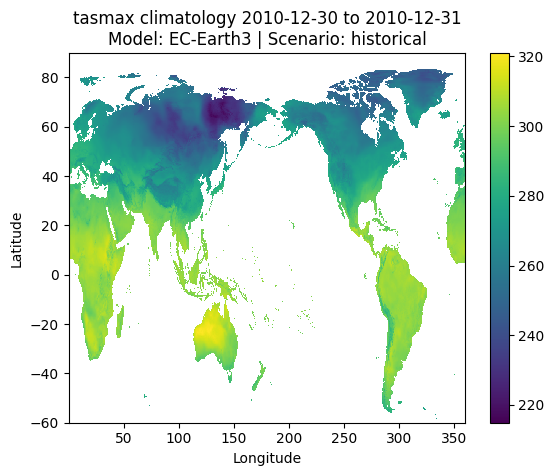

In [5]:
import matplotlib.pyplot as plt

plt.figure()
clim.plot()
plt.title(f"{SELECTED_VARIABLE} climatology {START_DATE} to {END_DATE}\n"
          f"Model: {SELECTED_MODEL} | Scenario: {SELECTED_SCENARIO}")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.show()

### Step 3 (Option) — Country Mask

Set a country name to mask the climatology (default: **United States of America**).  
If `geopandas`/`shapely` are not installed in your kernel, you'll get a clear message.

In [14]:
# Country to mask (set to None to skip masking)
COUNTRY = "Japan"

In [15]:
# Country dropdown (run this, then run the mask cell below)
import os, zipfile, urllib.request
import geopandas as gpd


# Ensure Natural Earth shapefile exists
shp_dir = "./ne_110m_admin_0_countries"
shp_file = shp_dir + ".shp"
if not os.path.exists(shp_file):
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    zip_path = "ne_countries.zip"
    print("Downloading Natural Earth shapefile...")
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(".")
    os.remove(zip_path)

world = gpd.read_file(shp_file)
name_col = "NAME" if "NAME" in world.columns else "ADMIN"
countries = sorted([c for c in world[name_col].astype(str).unique() if c])

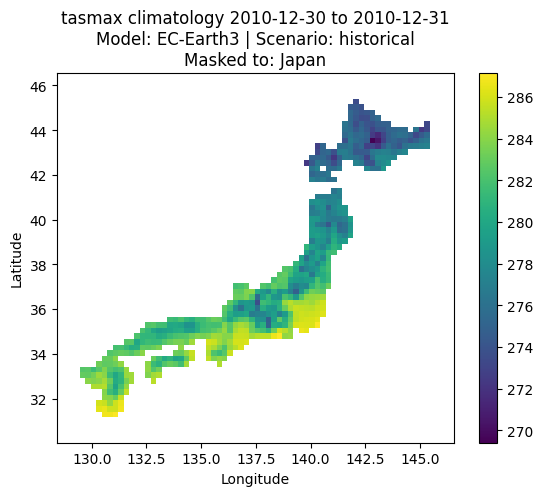

Area-mean tasmax over Japan for 2010-12-30 to 2010-12-31: 280.0723876953125


In [16]:

try:
    import os, zipfile, urllib.request
    import numpy as np
    import geopandas as gpd
    from shapely.ops import unary_union
    from shapely.geometry import Point
    from shapely import prepared as shapely_prepared
    import matplotlib.pyplot as plt
    import xarray as xr

    if COUNTRY is None:
        print("COUNTRY is None, skipping mask.")
    else:
        # Ensure Natural Earth shapefile is available
        shp_dir = "./ne_110m_admin_0_countries"
        shp_file = shp_dir + ".shp"
        if not os.path.exists(shp_file):
            url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
            zip_path = "ne_countries.zip"
            print("Downloading Natural Earth shapefile...")
            urllib.request.urlretrieve(url, zip_path)
            with zipfile.ZipFile(zip_path, "r") as z:
                z.extractall(".")
            os.remove(zip_path)

        world = gpd.read_file(shp_file)
        name_col = "NAME" if "NAME" in world.columns else ("ADMIN" if "ADMIN" in world.columns else None)
        if name_col is None:
            raise ValueError("Could not find country name column in Natural Earth file.")
        row = world[world[name_col] == COUNTRY]
        if row.empty:
            raise ValueError(f"Country '{COUNTRY}' not found in Natural Earth dataset.")

        geom = unary_union(row.geometry)
        minx, miny, maxx, maxy = geom.bounds
        prep = shapely_prepared.prep(geom)

        # Ensure lat/lon coordinate names
        clim2 = clim
        rename_map = {}
        for cand, std in (("latitude","lat"), ("Latitude","lat"), ("y","lat"),
                          ("longitude","lon"), ("Longitude","lon"), ("x","lon")):
            if cand in clim2.coords and std not in clim2.coords:
                rename_map[cand] = std
        if rename_map:
            clim2 = clim2.rename(rename_map)

        if not (("lat" in clim2.coords) and ("lon" in clim2.coords)):
            raise ValueError("Climatology lacks 'lat'/'lon' coordinates.")

        # Harmonize longitudes to [-180, 180] if data is 0..360
        lons = clim2["lon"].values
        if np.nanmax(lons) > 180.0:
            lons_adj = ((lons + 180.0) % 360.0) - 180.0
            clim2 = clim2.assign_coords(lon=("lon", lons_adj)).sortby("lon")
            lons = clim2["lon"].values

        lats = clim2["lat"].values
        Lon, Lat = np.meshgrid(lons, lats)

        # Build mask (True inside polygon)
        from shapely.geometry import Point
        pts = [Point(xy) for xy in zip(Lon.ravel(), Lat.ravel())]
        inside = np.array([prep.contains(p) for p in pts], dtype=bool).reshape(Lat.shape)

        clim_masked = clim2.where(inside)

        # Plot masked climatology with bbox extent
        fig, ax = plt.subplots()
        clim_masked.plot(ax=ax)
        pad_x = max(1.0, (maxx - minx) * 0.05)
        pad_y = max(1.0, (maxy - miny) * 0.05)
        ax.set_xlim(minx - pad_x, maxx + pad_x)
        ax.set_ylim(miny - pad_y, maxy + pad_y)
        ax.set_title(f"{SELECTED_VARIABLE} climatology {START_DATE} to {END_DATE}\n"
                     f"Model: {SELECTED_MODEL} | Scenario: {SELECTED_SCENARIO}\n"
                     f"Masked to: {COUNTRY}")
        ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
        plt.show()

        # Area mean (skip NaNs)
        country_mean = float(clim_masked.mean(("lat","lon"), skipna=True).values)
        print(f"Area-mean {SELECTED_VARIABLE} over {COUNTRY} for {START_DATE} to {END_DATE}: {country_mean}")

except Exception as e:
    print("Country mask step skipped due to error:", repr(e))